In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc; gc.collect()
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
train_df_path="../input/hpa-single-cell-image-classification/train.csv"
train_images_path="../input/hpa-single-cell-image-classification/train"
test_images_path="../input/hpa-single-cell-image-classification/test"
sample_df_path="../input/hpa-single-cell-image-classification/sample_submission.csv"

In [5]:

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image  
from IPython.display import display 


In [1]:
!pip install 'git+https://github.com/haoxusci/pytorch_zoo@master#egg=pytorch_zoo'

  Cloning https://github.com/haoxusci/pytorch_zoo (to revision master) to /tmp/pip-install-ub_xjtyq/pytorch-zoo_bbf9900342304ac0823ff5a431981c6f
  Running command git clone -q https://github.com/haoxusci/pytorch_zoo /tmp/pip-install-ub_xjtyq/pytorch-zoo_bbf9900342304ac0823ff5a431981c6f
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=138cae5942f3105ffa7a233c2acfe9dec178f55931b8560e63200552b6575822
  Stored in directory: /tmp/pip-ephem-wheel-cache-zptriqy5/wheels/51/c6/4b/db98c6ef97234d24a77e33d23b429e2f7e19bf2dfed8422a72
Successfully built pytorch-zoo


In [2]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

     - 17 kB 338 kB/ss/s
     \ 131 kB 501 kB/s/s
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14938 sha256=02bfab64aea4c69045c29beb790a2841789b81709397f98099e833f99b9d9a2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cairmgs/wheels/cd/d8/de/04ad08802d62537f8dffc89b6a7ce0a53c3d29ea6eae522ab1
Successfully built hpacellseg


In [3]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

In [6]:
ROOT_PATH = '/kaggle/input/hpa-single-cell-image-classification/'

CHANNELS = np.array(['red', 'green', 'blue', 'yellow'])

CHANNEL_RED = 0    # microtubule channels
CHANNEL_GREEN = 1  # protein of interest
CHANNEL_BLUE = 2   # nuclei channels
CHANNEL_YELLOW = 3 # endoplasmic reticulum 

CHANNEL_SIZE = len(CHANNELS)
SAMPLE_SIZE = 5

In [7]:
#
# Get array of all images for given sample id
#
def get_images(id):
    images = list()
    for channel in CHANNELS:
        path = ROOT_PATH + 'train/{}_{}.png'.format(id, channel)
        image = Image.open(path) 
        images.append(image)
    return images

In [10]:
#
# Get single image that blends all RGBY into RGB
#
def get_blended_image(id): 
    # get rgby images for sample
    images = get_images(id)

    # blend rgby images into single array
    blended_array = np.stack((
            images[0],
            images[1],
            images[2]
        ), 2)

    # Create PIL Image
    blended_image = Image.fromarray( np.uint8(blended_array) )
    return blended_image

In [12]:
df_train = pd.read_csv(ROOT_PATH + 'train.csv')
print("Training data length: {}".format(len(df_train)))
df_train.head()

Training data length: 21806


,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [13]:
# if sample size is set then reduce trainning set accordingly
if SAMPLE_SIZE > -1:
    df_train = df_train.sample(SAMPLE_SIZE)
    df_train.reset_index(inplace=True);

In [14]:
NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)


No GPU found, using CPU.
Could not find ./nuclei-model.pth. Downloading it now


please compile abn


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [15]:
# id to use while exploring
# sample_id = df_train['ID'].iloc[0]
sample_id='0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0'

images = get_images(sample_id)

nuc_segmentations = segmentator.pred_nuclei([np.asarray( images[CHANNEL_BLUE] )])
print(np.shape(nuc_segmentations))

# For full cells
cell_segmentations = cell_segmentations = segmentator.pred_cells([
        [np.asarray( images[CHANNEL_RED] )],
        [np.asarray( images[CHANNEL_GREEN] )],
        [np.asarray( images[CHANNEL_BLUE] )]
    ])
print(np.shape(cell_segmentations))
   

(1, 2048, 2048, 3)
(1, 2048, 2048, 3)


In [16]:
nuclei_mask = label_nuclei(nuc_segmentations[0])
print(np.shape(nuclei_mask))

cell_nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
print(np.shape(nuclei_mask))
print(np.shape(cell_mask))

(2048, 2048)
(2048, 2048)
(2048, 2048)


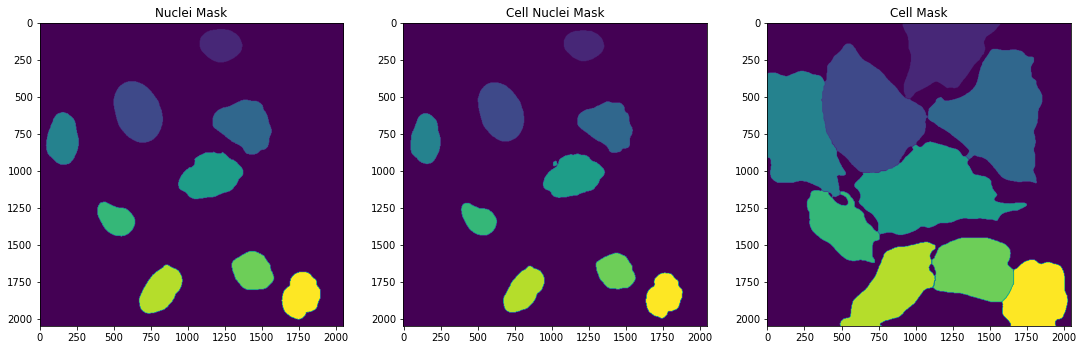

In [17]:
fig = plt.figure(figsize=(25,25))

# Nuclei mask
nuclei_image = Image.fromarray( np.uint8(nuclei_mask) )

ax = fig.add_subplot(1, 4, 1)
ax.set_title("Nuclei Mask")
plt.imshow(np.asarray(nuclei_image))

# Cell nuclei mask
cell_nuclei_image = Image.fromarray( np.uint8(cell_nuclei_mask) )

ax = fig.add_subplot(1, 4, 2)
ax.set_title("Cell Nuclei Mask")
plt.imshow(np.asarray(cell_nuclei_image))

# Cell mask
cell_image = Image.fromarray( np.uint8(cell_mask) )

ax = fig.add_subplot(1, 4, 3)
ax.set_title("Cell Mask")
plt.imshow(np.asarray(cell_image))


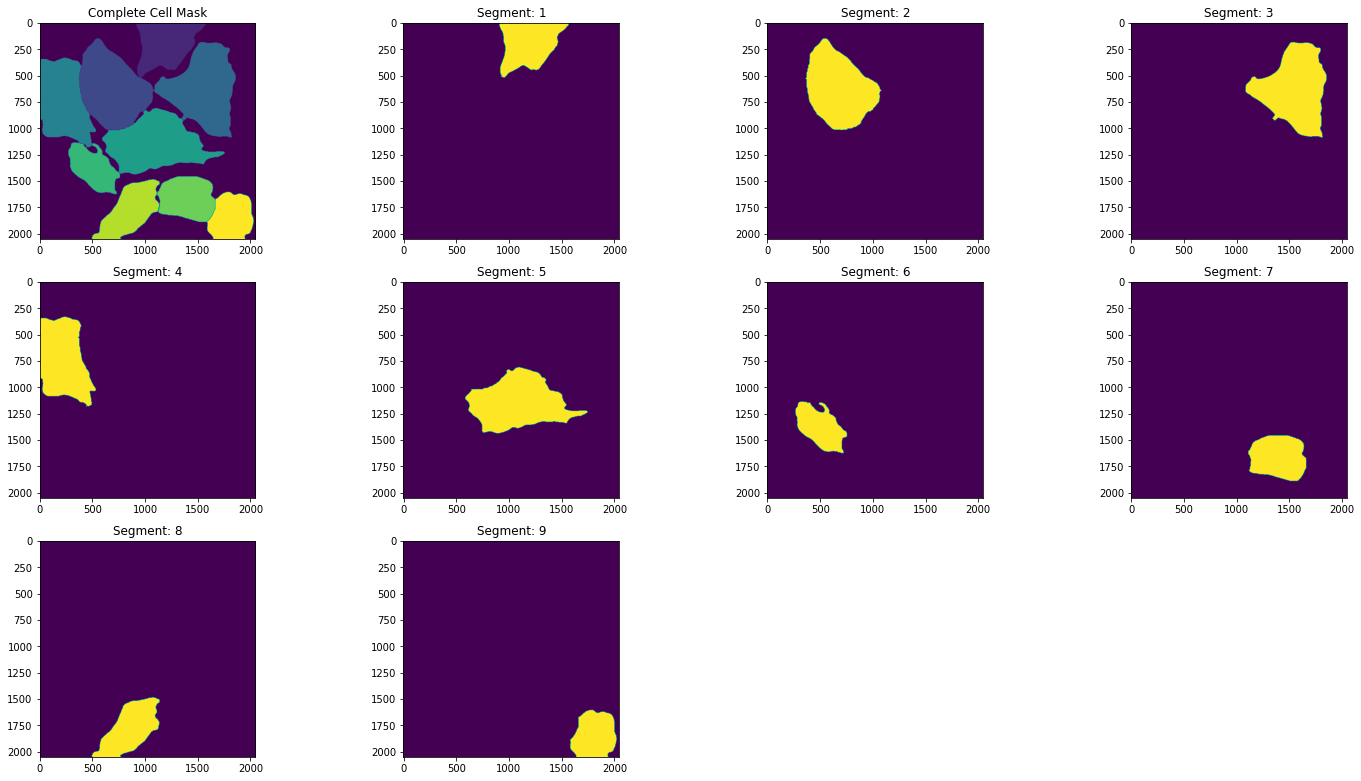

In [18]:
# Get unique vector of segment numbers
numbers = set( np.ravel(cell_mask) )
numbers.remove(0)

fig = plt.figure(figsize=(25,6*len(numbers)/4))
index = 1

# plot original cell mask from above
ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
ax.set_title("Complete Cell Mask")
plt.imshow(np.asarray(cell_image))
index = index + 1

for number in numbers:
    # set all other 'numbers' to zero in cell mask
    isolated = np.where(cell_mask == number, cell_mask, 0)

    # plot isolated image
    ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
    ax.set_title("Segment: {}".format(number))

    plt.imshow(isolated)
    index = index + 1

In [24]:
def smallestbox(a,b):
    r = a.any(1)
    if r.any():
        m,n = a.shape
        c = a.any(0)
        out = b[r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
    else:
        out = np.empty((0,0),dtype=bool)
    return out

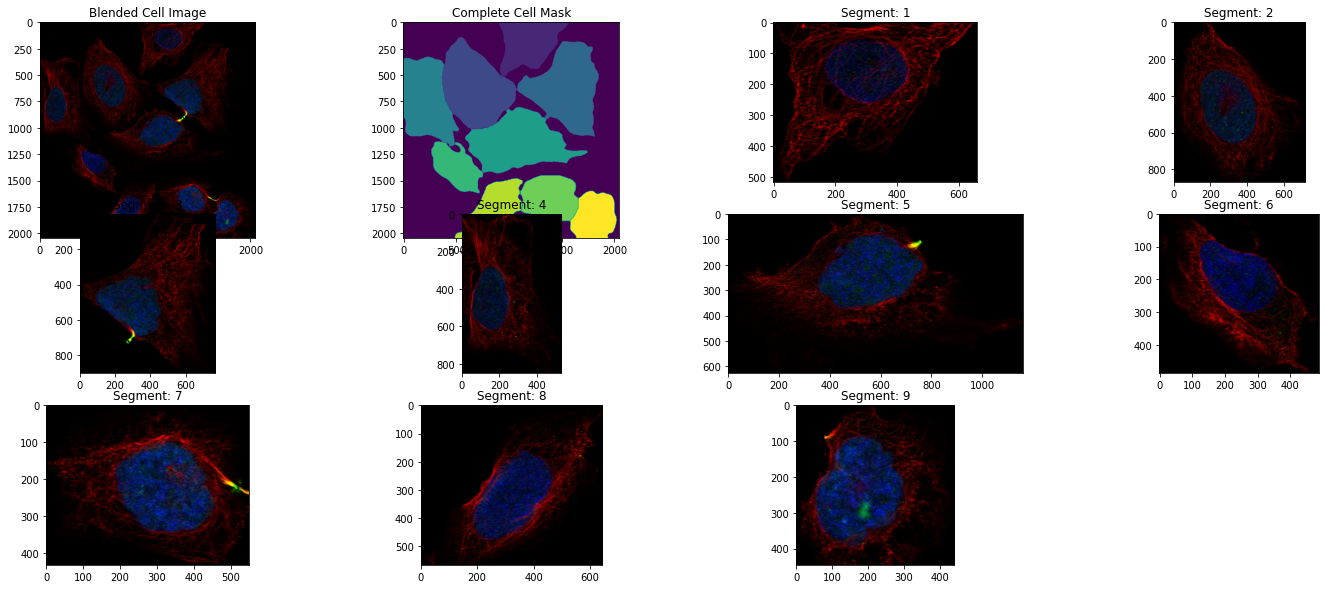

In [25]:
blended_image = get_blended_image(sample_id)
blended_array = np.asarray(blended_image)

# Get unique vector of segment numbers
numbers = np.unique(cell_mask)
numbers = np.delete(numbers, [0])

# build figure
fig = plt.figure(figsize=(25,6*len(numbers)/4))
index = 1

# plot original cell mask from above
ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
ax.set_title("Blended Cell Image")
plt.imshow(np.asarray(blended_image))
index = index + 1

# plot original cell mask from above
ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
ax.set_title("Complete Cell Mask")
plt.imshow(np.asarray(cell_image))
index = index + 1

for number in numbers:
    # set all other 'numbers' to 255 in cell mask
    isolated_mask = np.where(cell_mask == number, True, False)
    isolated_mask1 = isolated_mask
    # match shape for RGB
    isolated_mask = np.stack((isolated_mask, isolated_mask, isolated_mask), axis=2)
    
    # crop across all channels
    isolated_image = np.where(isolated_mask == True, blended_array, 0)
    isolated_image1 = smallestbox(isolated_mask1,isolated_image)
    # plot isolated image
    ax = fig.add_subplot((len(numbers)//4)+2, 4, index)
    ax.set_title("Segment: {}".format(number))

    plt.imshow(isolated_image1)
    index = index + 1